# Bayesian Modeling

What if we want to avoid choosing specific colorfulness values for each painting?

We can use Monte-Carlo methods to find distributions over changepoints

In [98]:
import numpy as np
import cv2
import scipy.stats

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

import os
import sys
sys.path.append('..')

import image_measures
import visual_plot
import changepoint_estimation


from sklearn.neighbors import KernelDensity

In [99]:
# path to your wikiart images folder
wikiart_path = '/media/sam/bbdb3901-f357-4a4f-b198-3102f6046fab/wikiart/images/'

In [100]:
artist_name = 'mark-rothko'

In [101]:
image_paths = []
years = []
names = []
for path in os.listdir(wikiart_path):
    if path == artist_name:
        subdir = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(wikiart_path + path)) for f in fn]
        images = [s for s in subdir if s.split('.')[-1] in ('jpg', 'gif', 'png')]
        image_paths += images
        years += [i.split('/')[-2] for i in images]
        names += [i.split('/')[-3] for i in images]

In [102]:
years = np.array([np.nan if y == 'unknown-year' else int(y) for y in years])

In [103]:
# compute colorfulness and complexity scores for the images we've selected

colorfulness = []
complexity = []
for i,image_path in enumerate(image_paths):
    try:
        colorfulness.append(image_measures.colorfulness(cv2.imread(image_path)))
        complexity.append(image_measures.complexity(cv2.imread(image_path)))
    except Exception as e:
        print(e)
        print(image_path)
        colorfulness.append(np.nan)
        complexity.append(np.nan)

In [64]:
# let's assume we have uncertain measures, with normally distributed error around each value
# These could have any amount of uncertainty, let's set each to a standard deviation of 10%

complexity_std = 0.1 * np.array(complexity)
colorfulness_std = 0.1 * np.array(colorfulness)


In [67]:
mask

array([False, False, False, ...,  True, False,  True])

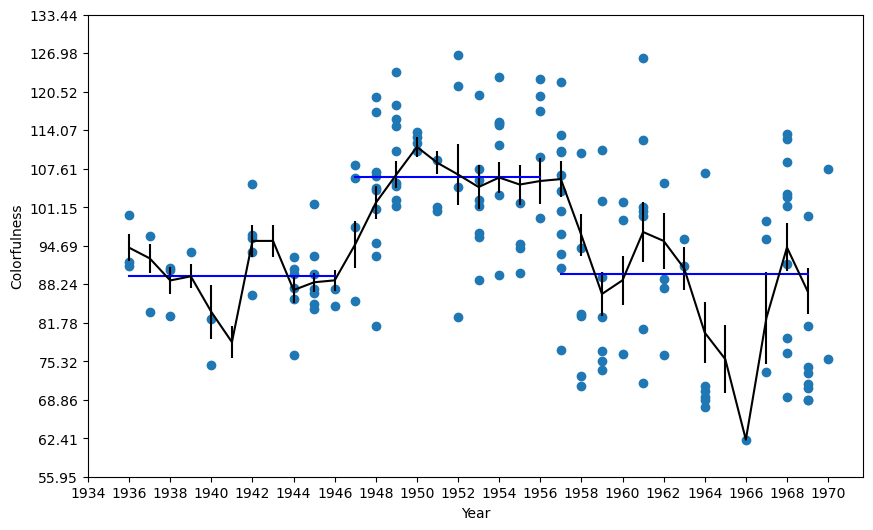

In [69]:
mask = ~np.isnan(colorfulness) & ~np.isnan(years)
fig, ax = plt.subplots(figsize=(10,6))
visual_plot.plot_without_images(years[mask], np.array(colorfulness)[mask], ax=ax, model='constant')
ax.set_xticks(range(1934,1972,2))
plt.xlabel('Year')
plt.ylabel('Colorfulness')
plt.show()

In [70]:
n_changepoints = 2

results = []
reg_params = []
for sample in range(1000):
    colorfulness_sample = np.random.normal(0,colorfulness_std, len(colorfulness)) + np.array(colorfulness)
    mask = ~np.isnan(colorfulness_sample) & ~np.isnan(years)
    boundaries, stderr = changepoint_estimation.find_changepoints(
        years[mask], colorfulness_sample[mask], n_changepoints, 'constant')
    results.append(boundaries)
    
    changepoints = [np.nanmin(years)] + boundaries + [np.nanmax(years)]
    reg_params.append([])
    for i in range(1, len(changepoints)):
        segment_mask = (
            np.less(years, changepoints[i]) 
            & np.greater_equal(years, changepoints[i-1]) 
            & mask
            )
        #if np.sum(segment_mask) < 2 or (changepoints[i] - changepoints[i-1]) <= 1:
        #    continue

        #m,b,r,p,s = scipy.stats.linregress(years[segment_mask], 
        #                                              colorfulness_sample[segment_mask])
        #reg_params[-1].append([m,b])
        reg_params[-1].append(np.mean(colorfulness_sample[segment_mask]))

KeyboardInterrupt: 

In [ ]:
results = np.array(results)
reg_params = np.array(reg_params)

In [ ]:
mean_results = results.mean(axis=0)
std_results = results.std(axis=0)

In [ ]:
mean_params = reg_params.mean(axis=0)
conf_interval_params = np.quantile(reg_params, [0.025, 0.975], axis=0)

In [ ]:
conf_interval_params

In [ ]:
fig = plt.figure(figsize=(10,6))
gs = fig.add_gridspec(2, 1, height_ratios=(1, 4),
                      bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.1)

ax = fig.add_subplot(gs[1, 0])
ax_hist = fig.add_subplot(gs[0, 0], sharex=ax)
ax.errorbar(years, colorfulness, yerr=colorfulness_std, fmt="o")
ax.set_xlim(np.nanmin(years) - 1, np.nanmax(years) + 1)
ax.set_ylim(0, np.nanmax(colorfulness) + max(colorfulness_std))
colors = ['red', 'orange', 'forestgreen']
for cp in range(n_changepoints):
    #|ax_hist.scatter(results[:,cp], [0] * len(results), c=colors[cp])
    mean = mean_results[cp]
    std = std_results[cp]
    sup = np.linspace(np.nanmin(years), np.nanmax(years), 1000)
    
    kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(results[:,cp].reshape([-1,1]))
    ax_hist.hist(results[:,cp], color=colors[cp])
    #ax_hist.plot(sup, np.exp(kde.score_samples(sup.reshape([-1,1]))), c=colors[cp])
    #ax_hist.plot(sup, scipy.stats.norm.pdf(sup, mean, std), c=colors[cp])
    ax.plot([mean, mean], [0, np.nanmax(colorfulness) + 1], '--', c=colors[cp])
    
    
changepoints = [np.nanmin(years)] + list(mean_results) + [np.nanmax(years)]
for cp in range(len(changepoints[:-1])):
    X = np.linspace(changepoints[cp], changepoints[cp+1], 10)
    Y = mean_params[cp]
    Y_min = conf_interval_params[0,cp]
    Y_max = conf_interval_params[1,cp]
    ax.plot(X,[Y] * len(X), color='blue')
    ax.fill_between(X, Y_min,Y_max, facecolor='blue', alpha=0.2)
    
ax.set_xlabel('Year')
ax.set_ylabel('Colorfulness')
plt.show()

What if we want to do Bayesian analysis for real? Like, finding a distribution over changepoints by computing the posterior?

Then we need a prior over changepoints

In [104]:
%load_ext autoreload
%autoreload
import changepoint_estimation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
mask = ~np.isnan(colorfulness) & ~np.isnan(years)

year_indices = sorted(set(years[mask]))
prior = np.ones_like(year_indices) * 0.1
prior[year_indices.index(1949)] = 1

splits, log_map, posterior_table = changepoint_estimation.find_changepoint_posterior(
    years[mask], np.array(colorfulness)[mask], 2, 
    prior_over_periods=prior, prior_mu=20, prior_sigma=100)

In [106]:
splits

[1947.0, 1958.0]

In [107]:
candidates = sorted(set(years[mask]))
options = range(len(candidates))
marginal_posterior_1 = np.log(prior) + posterior_table[0,options,0] + posterior_table[options,len(candidates),1]
marginal_posterior_1 -= scipy.special.logsumexp(marginal_posterior_1)

marginal_posterior_2 = np.log(prior) + posterior_table[0,options,1] + posterior_table[options,len(candidates),0]
marginal_posterior_2 -= scipy.special.logsumexp(marginal_posterior_2)

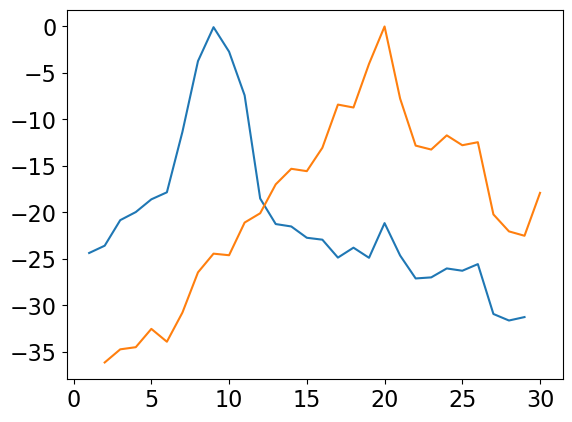

In [108]:
plt.plot(marginal_posterior_1)
plt.plot(marginal_posterior_2)

In [109]:
np.nanmin(feature)

62.16657899914278

[1936.0, 1947.0, 1958.0, 1971.0]
[89] [[1]]
[105] [[1]]
[87] [[2]]


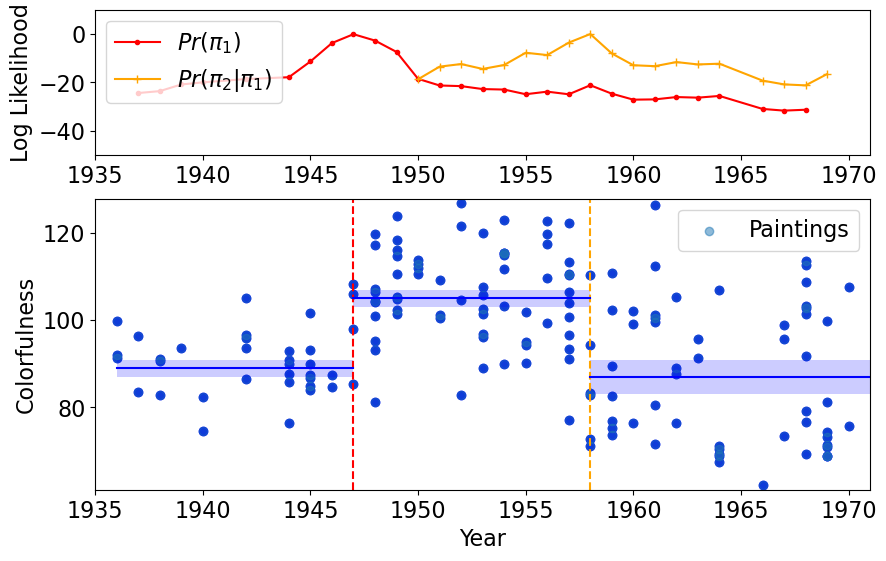

In [113]:
fig = plt.figure(figsize=(10,6))
gs = fig.add_gridspec(2, 1, height_ratios=(1, 2),
                      bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.2)

feature = np.array(colorfulness)

ax = fig.add_subplot(gs[1, 0])
ax_hist = fig.add_subplot(gs[0, 0], sharex=ax)
ax.scatter(years, colorfulness, color='blue')
ax.set_xlim(np.nanmin(years) - 1, np.nanmax(years) + 1)
ax.set_ylim(np.nanmin(feature) - 1, np.nanmax(feature) + 1)
n_splits = len(splits)
if n_splits > 0:
    changepoints = [np.nanmin(years)] + list(splits) + [np.nanmax(years) + 1]
    print(changepoints)
    conditional_posteriors = []
    for i in range(n_splits):
        options_this_split = options[int(changepoints[i] - np.nanmin(years)):]
        conditional_posterior = (
            np.log(prior[options_this_split]) 
            + posterior_table[int(changepoints[i] - np.nanmin(years)),options_this_split,0] 
            + posterior_table[options_this_split,len(candidates),n_splits-1-i]
        )
        conditional_posterior -= scipy.special.logsumexp(conditional_posterior)
        conditional_posteriors.append(conditional_posterior)
    colors = ['red', 'orange', 'forestgreen', 'purple', 'sienna']
    markers = ['.', '+', '^', 's', '*']
    labels = ['$Pr(\pi_1)$'] + ['$Pr(\pi_{} | \pi_{})$'.format(i+1, i) for i in range(1,len(colors))]
    
    for i,p in enumerate(conditional_posteriors):
        options_this_split = options[int(changepoints[i] - np.nanmin(years)):]
        ax_hist.plot(np.array(candidates)[options_this_split],p, color=colors[i],
                       marker=markers[i], label=labels[i])
        ax.plot([splits[i], splits[i]],[np.nanmin(feature) - 1, np.nanmax(feature) + 1], '--', color=colors[i])
    ax.scatter(years[mask], feature[mask], alpha=0.5, label='Paintings')
    
    
    for cp in range(len(changepoints[:-1])):
        X = np.linspace(changepoints[cp], changepoints[cp+1], 10)
        x_values, y_values = changepoint_estimation.range_filter(years[mask], np.array(feature)[mask], 
                                                       changepoints[cp], changepoints[cp+1])
        mu, sigma = changepoint_estimation.update_model(y_values, 20, 100)
        print(mu, sigma)
        Y = mu[0]
        Y_min = scipy.stats.norm.ppf(0.025, mu[0], sigma[0,0])
        Y_max = scipy.stats.norm.ppf(0.975, mu[0], sigma[0,0])
        ax.plot(X,[Y] * len(X), color='blue')
        ax.fill_between(X, [Y_min] * len(X),[Y_max] * len(X), facecolor='blue', alpha=0.2)
    
ax.set_xlabel('Year')
ax.set_ylabel('Colorfulness')
ax_hist.set_ylabel('Log Likelihood')
ax_hist.set_ylim(-50,10)
ax_hist.legend()
ax.legend()
plt.savefig('rothko_periods.pdf', bbox_inches='tight')

In [114]:
artist_name = 'pablo-picasso'

In [115]:
def mean_hue(im):
    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    
    hue = hsv[:,:,0].flatten()
    sat = np.abs(hsv[:,:,1].flatten())
    if np.sum(sat) == 0: return np.nan
    else: return np.average(hue, weights=sat)

In [116]:
image_paths = []
years = []
names = []
for path in os.listdir(wikiart_path):
    if path == artist_name:
        subdir = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(wikiart_path + path)) for f in fn]
        images = [s for s in subdir if s.split('.')[-1] in ('jpg', 'gif', 'png')]
        image_paths += images
        years += [i.split('/')[-2] for i in images]
        names += [i.split('/')[-3] for i in images]

In [117]:
years = np.array([np.nan if y == 'unknown-year' else int(y) for y in years])

In [118]:
# compute colorfulness and complexity scores for the images we've selected

#colorfulness = []
mean_hues = []
#complexity = []
for i,image_path in enumerate(image_paths):
    try:
        mean_hues.append(mean_hue(cv2.imread(image_path)))
        #complexity.append(image_measures.complexity(cv2.imread(image_path)))
        #mean_colors.append(mean_color(cv2.imread(image_path)))
    except Exception as e:
        print(e)
        print(image_path)
        #colorfulness.append(np.nan)
        #complexity.append(np.nan)
        mean_hues.append(np.nan)

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


In [119]:
%load_ext autoreload
%autoreload
import changepoint_estimation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


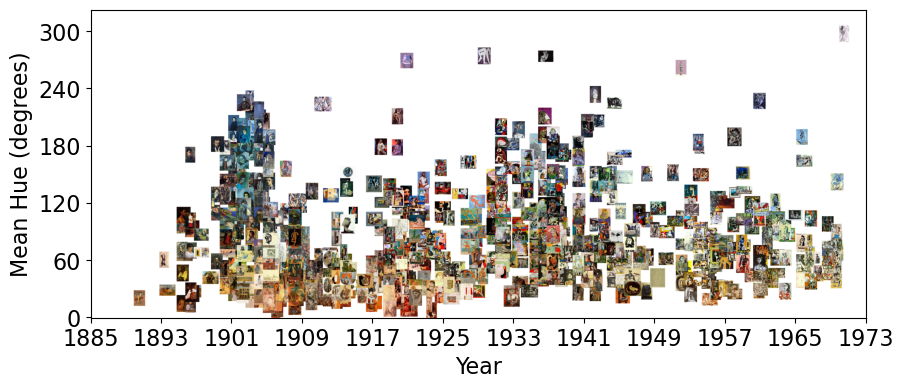

In [121]:
fig, ax = plt.subplots(figsize=(10,4))
X = np.array(years)
Y = np.array(mean_hues) * 2
mask = ~np.isnan(np.array(X)) & ~np.isnan(np.array(Y))
ax, ranges, x_coord, y_coord = visual_plot.plot_images(
    X[mask],Y[mask], [image_paths[i] for i in range(len(image_paths)) if mask[i]], 
    target_image_resolution=100, canvas_shape=(2000,5000,3), ax = ax
)
X_min, X_max, Y_min, Y_max = ranges
Y_range = Y_max - Y_min
X_range = X_max - X_min
ax.set_yticks(
    [y_coord(y) for y in np.arange(
        0, 360, 60
    )]
)
ax.set_yticklabels(
    [round(s,2) for s in np.arange(0, 360, 60)]
)
ax.set_xticks(
    [x_coord(x) for x in np.arange(X_min - 5, X_max + 5, X_range/10)]
)
ax.set_xticklabels(
    np.arange(X_min - 5, X_max + 5, X_range/10, dtype=int)
)
plt.xlabel('Year')
plt.ylabel('Mean Hue (degrees)')
plt.savefig('picasso_images.pdf', bbox_inches='tight')

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


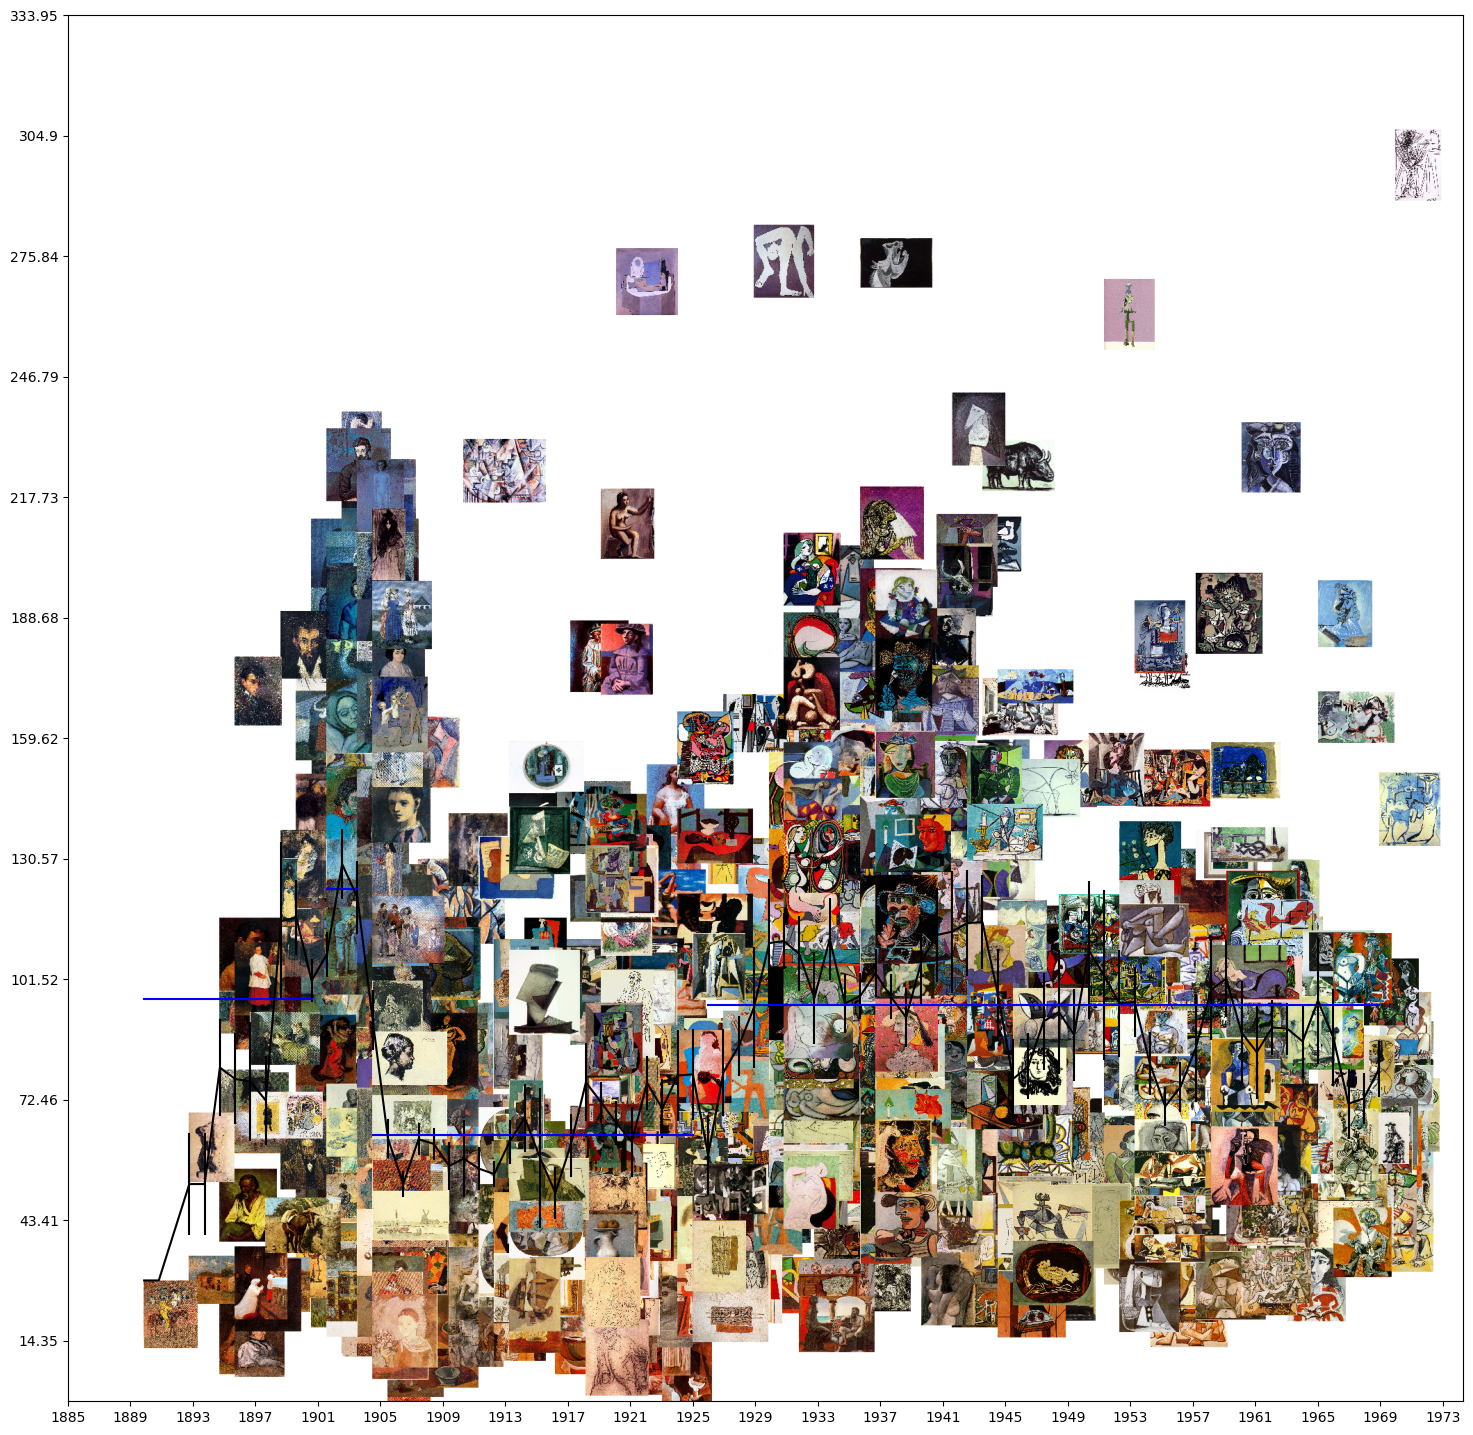

In [38]:
visual_plot.visual_plot(X[mask],Y[mask], [image_paths[i] for i in range(len(image_paths)) if mask[i]], 
                        target_image_resolution=100, model='constant')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[1890.0, 1973.0]
[1890.0, 1905.0, 1973.0]
[1890.0, 1906.0, 1928.0, 1973.0]
[1890.0, 1906.0, 1918.0, 1930.0, 1973.0]
[1890.0, 1906.0, 1918.0, 1930.0, 1956.0, 1973.0]
[1890.0, 1902.0, 1906.0, 1918.0, 1930.0, 1956.0, 1973.0]
[1890.0, 1902.0, 1906.0, 1918.0, 1930.0, 1931.0, 1956.0, 1973.0]
[1890.0, 1902.0, 1905.0, 1906.0, 1918.0, 1930.0, 1931.0, 1956.0, 1973.0]


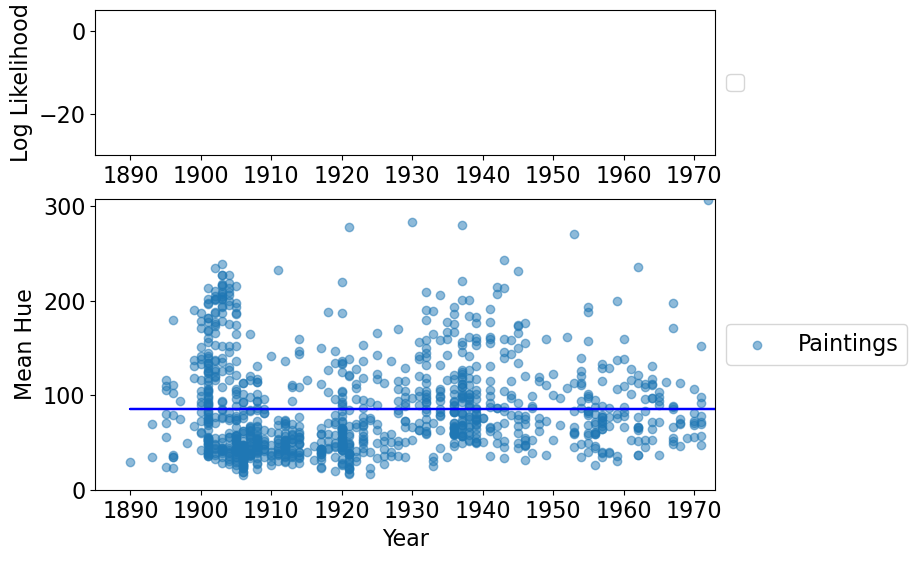

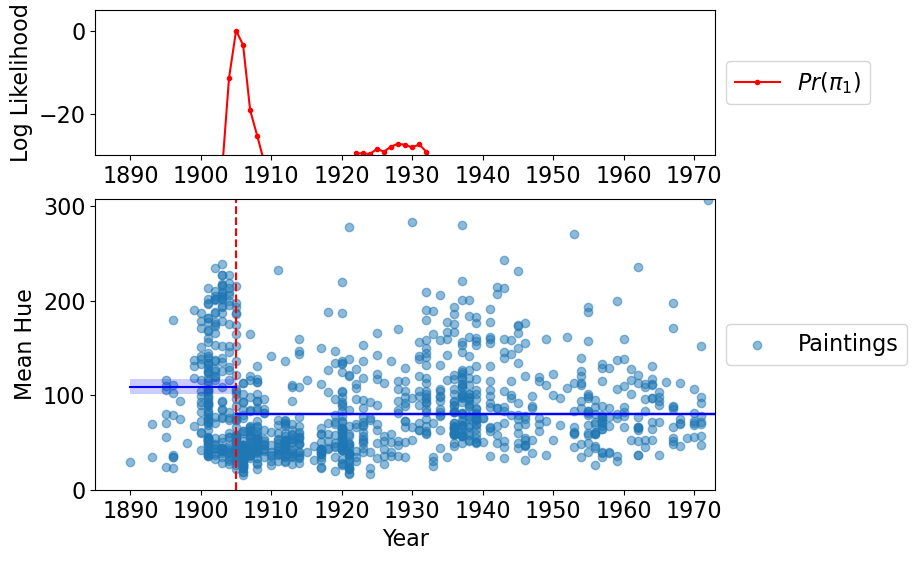

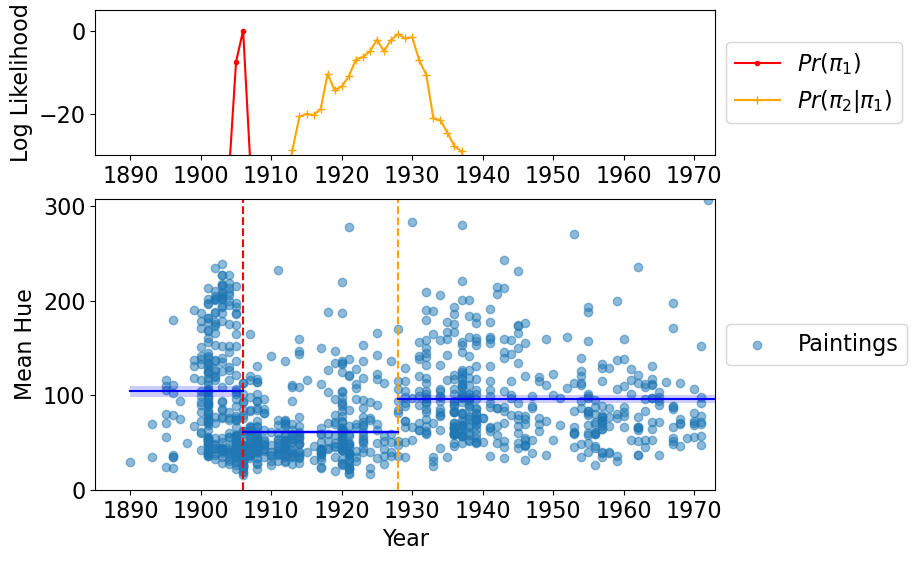

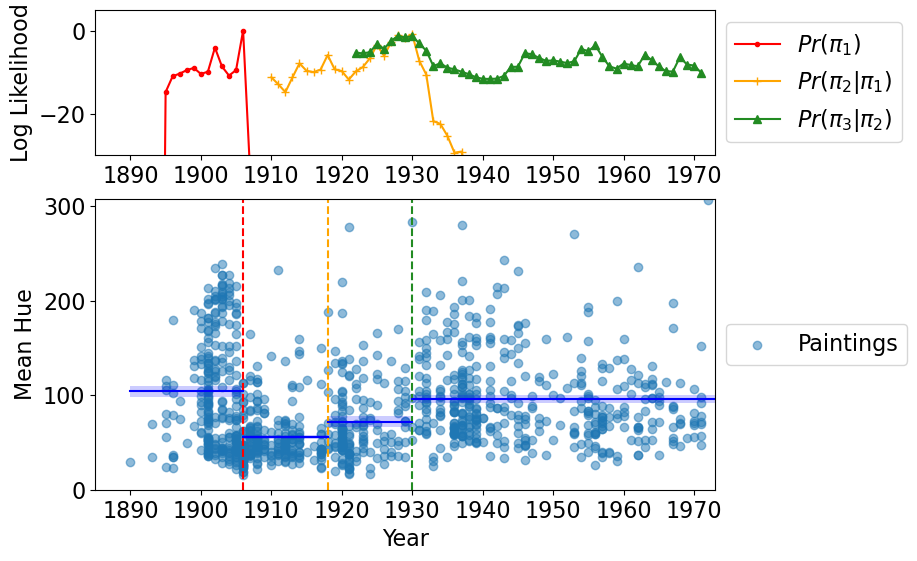

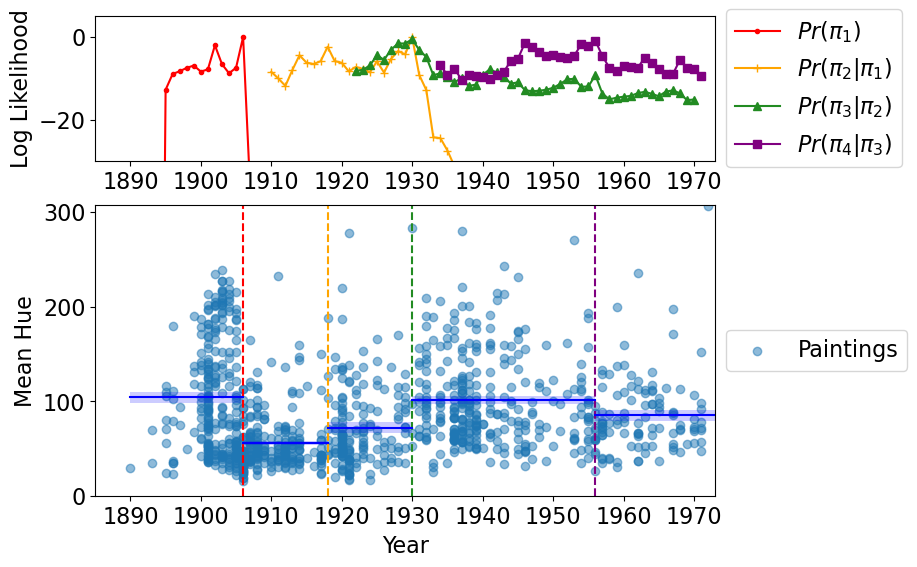

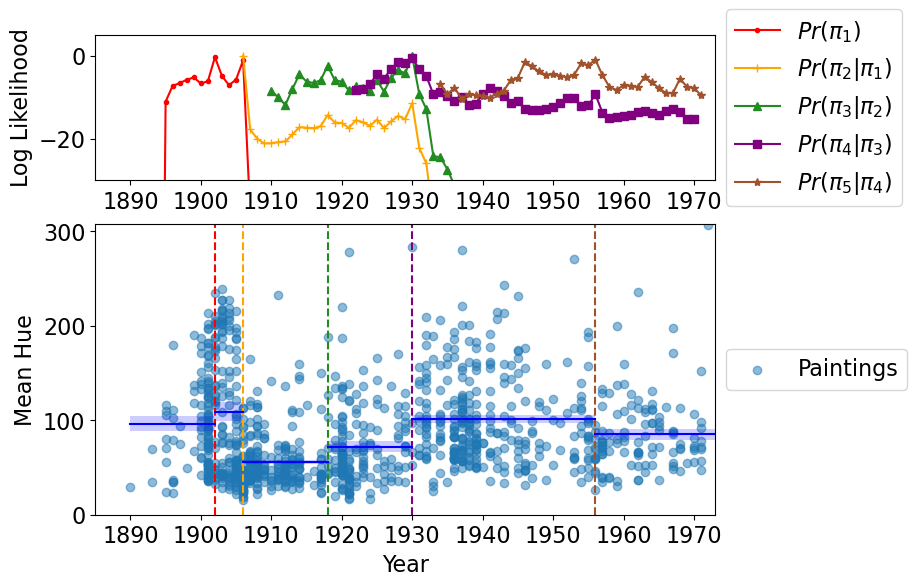

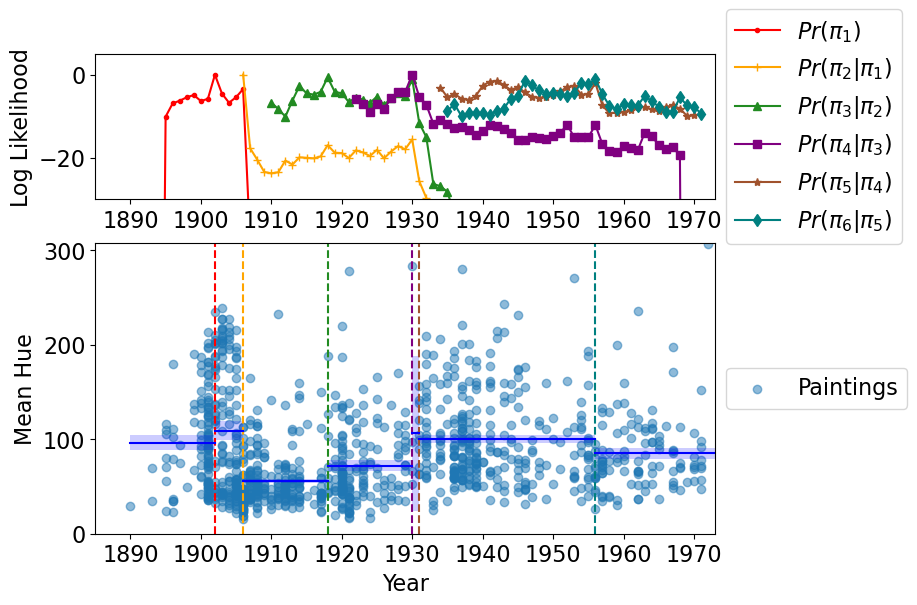

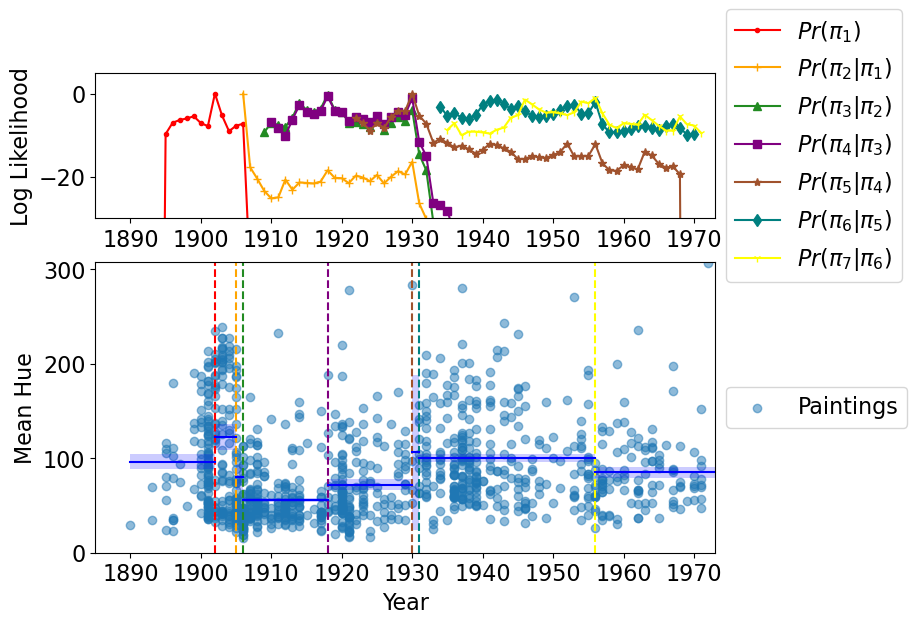

In [127]:
feature = np.array(mean_hues) * 2
feature_name = 'Mean Hue'

BIC_values = []

for n_splits in range(8):
    mask = ~np.isnan(feature) & ~np.isnan(years)

    year_indices = sorted(set(years[mask]))
    prior = np.ones_like(year_indices)

    splits, log_posterior, posterior_table = changepoint_estimation.find_changepoint_posterior(
        years[mask], np.array(feature)[mask], n_splits, 
        prior_over_periods=prior, prior_mu=180.0, prior_sigma=30.0)
    
    log_likelihood = changepoint_estimation.model_likelihood(years[mask], feature[mask], 
                                                                   splits, 180.0, 180.0)
    
    total_params = (n_splits + 1) + n_splits
    BIC_values.append(changepoint_estimation.BIC_log_likelihood(total_params, sum(mask), log_likelihood))
    
    fig = plt.figure(figsize=(10,6))
    gs = fig.add_gridspec(2, 1, height_ratios=(1, 2),
                          bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.2)
    ax = fig.add_subplot(gs[1, 0])
    ax_hist = fig.add_subplot(gs[0, 0], sharex=ax)
    
    candidates = sorted(set(years[mask]))
    options = range(len(candidates))
    changepoints = [np.nanmin(years)] + list(splits) + [np.nanmax(years) + 1]
    if n_splits > 0:
        conditional_posteriors = []
        for i in range(n_splits):
            options_this_split = options[int(changepoints[i] - np.nanmin(years)):]
            conditional_posterior = (
                np.log(prior[options_this_split] / np.sum(prior[options_this_split])) 
                + posterior_table[int(changepoints[i] - np.nanmin(years)),options_this_split,0] 
                + posterior_table[options_this_split,len(candidates),n_splits-1-i]
            )
            conditional_posterior -= scipy.special.logsumexp(conditional_posterior)
            conditional_posteriors.append(conditional_posterior)
        colors = ['red', 'orange', 'forestgreen', 'purple', 'sienna', 'teal', 'yellow']
        markers = ['.', '+', '^', 's', '*', 'd', '1']
        labels = ['$Pr(\pi_1)$'] + ['$Pr(\pi_{} | \pi_{})$'.format(i+1, i) for i in range(1,len(colors))]
        for i,p in enumerate(conditional_posteriors):
            options_this_split = options[int(changepoints[i] - np.nanmin(years)):]
            ax_hist.plot(np.array(candidates)[options_this_split],p, color=colors[i],
                       marker=markers[i], label=labels[i])
            ax.plot([splits[i], splits[i]],[0, np.nanmax(feature) + 1], '--', c=colors[i])
    ax.scatter(years[mask], feature[mask], alpha=0.5, label='Paintings')
    ax.set_xlim(np.nanmin(years) - 5, np.nanmax(years) + 1)
    ax.set_ylim(0, np.nanmax(feature) + 1)
    changepoints = [np.nanmin(years)] + list(splits) + [np.nanmax(years) + 1]
    print(changepoints)
    for cp in range(len(changepoints[:-1])):
        X = np.linspace(changepoints[cp], changepoints[cp+1], 10)
        x_values, y_values = changepoint_estimation.range_filter(years[mask], np.array(feature)[mask], 
                                                       changepoints[cp], changepoints[cp+1])
        mu, sigma = changepoint_estimation.update_model(y_values, 20, 100)
        Y = mu[0]
        Y_min = scipy.stats.norm.ppf(0.025, mu[0], sigma[0,0])
        Y_max = scipy.stats.norm.ppf(0.975, mu[0], sigma[0,0])
        ax.plot(X,[Y] * len(X), color='blue')
        ax.fill_between(X, [Y_min] * len(X),[Y_max] * len(X), facecolor='blue', alpha=0.2)

    ax.set_xlabel('Year')
    ax.set_ylabel(feature_name)
    ax_hist.set_ylabel('Log Likelihood')
    ax_hist.set_ylim([-30,5])
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    box = ax_hist.get_position()
    ax_hist.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax_hist.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig('picasso_{}_splits.pdf'.format(n_splits), bbox_inches='tight')

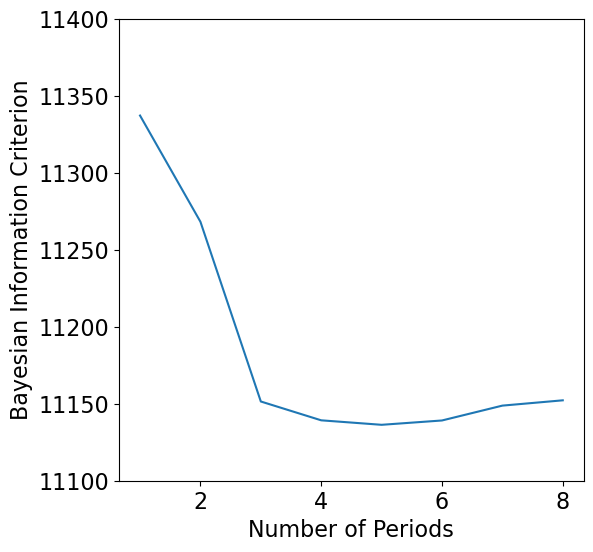

In [92]:
plt.subplots(figsize=(6,6))
plt.plot(np.arange(1,9), BIC_values)
plt.xlabel('Number of Periods')
plt.ylabel('Bayesian Information Criterion')
plt.ylim(11100,11400)
plt.savefig('picasso_BIC.pdf', bbox_inches='tight')